# IoU

In [9]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import torch

from torchmetrics import JaccardIndex
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from initialize import initialize_model, load_config
from dataset import Dataset

In [10]:
dataset_config = {
  **load_config("./dataset.cfg"),
  "datasets_dir": "../../../../../datasets"
}

In [2]:
# Load Split Indexes
train_indexes = np.load("./train_indexes.npy")
test_indexes = np.load("./test_indexes.npy")

print(f"train_indexes ({len(train_indexes)}): {train_indexes}")
print(f"test_indexes ({len(test_indexes)}): {test_indexes}")

train_indexes (120): [123  89 103  10 157   2 158 121  72 109  19  65  91  66  33  25 102  64
  59 118 141  60   7  14  70  79 130  53 115 122  96  63  97 136  36 135
  42  56  15  27 129  93 107  24   4  31  40  95  18 144  67  92 119 154
  78  84  62  87 142   6  76 146  51 155 124 156 143  20  61 101 106 131
  43  90 153  44 127 151  45  21  46 140  16 149 108 152 120  11 125  13
  28  82  86  69  88  39 132 114 150  98  54  30 134 116   9   8  37  38
 111 139  81  71  57  50  26  49   1  75  41 105]
test_indexes (39): [148  58  55  22 110  68 147 100  34  32 133  48  80  52  94   5 126 117
  73  83  17 104 113  29  85 138  99  12 128  74   0 112  35  77  23 137
  47   3 145]


In [3]:
EPOCH = 1000

In [4]:
jaccard = JaccardIndex(task="multiclass", num_classes=2)
jaccard_ignore = JaccardIndex(task="multiclass", num_classes=2, ignore_index=0)

if not os.path.isdir("iou"):
    os.mkdir("iou")

# epochs_iou = []
# epochs_iou_ignore = []
# epochs_predictions = []

with open(f"./targets.p", "rb") as targets_file:
    targets = pickle.load(targets_file)

test_length = len(test_indexes)

if not os.path.isdir(f"iou/{EPOCH}"):
    os.mkdir(f"iou/{EPOCH}")

build_layers_iou = []
build_layers_iou_ignore = []
for index in range(test_length):
    predictions = []

    with open(f"./predictions/{EPOCH}.p", "rb") as predictions_file:
        predictions = pickle.load(predictions_file)

    prediction = predictions[index].squeeze()
    # prediction = np.transpose(prediction, (1, 0, 2))

    target = targets[index].squeeze()
    # target = np.transpose(target, (1, 0, 2))

    # print(prediction.shape)

    build_layer_iou = jaccard(torch.tensor(prediction), torch.tensor(target))
    build_layer_iou_ignore = jaccard_ignore(torch.tensor(prediction), torch.tensor(target))

    # Sets correct prediction of no pores to 1.
    prediction_not_empty = np.any(np.array(prediction) == 1)
    target_not_empty = np.any(np.array(target) == 1)

    # print(np.unique(prediction), np.unique(target))

    if (not target_not_empty):
        build_layer_iou_ignore = torch.tensor(0.0)
        build_layer_iou = torch.tensor(0.0)

    if (not prediction_not_empty and not target_not_empty):
        # print(index, prediction_not_empty, target_not_empty)
        build_layer_iou_ignore = torch.tensor(1.0)
        build_layer_iou = torch.tensor(1.0)

    build_layers_iou.append(build_layer_iou)
    build_layers_iou_ignore.append(build_layer_iou_ignore)

predictions_numpy = []
targets_numpy = []

for prediction in predictions:
    # print(prediction.shape)
    predictions_numpy.append(np.array(prediction))

for target in targets:
    # print(target.shape)
    targets_numpy.append(np.array(target))

predictions = np.array(predictions_numpy)
targets = np.array(targets_numpy)

# predictions = np.array([value for _, value in sorted(zip(test_indexes, predictions))])
# targets = np.array([value for _, value in sorted(zip(test_indexes, targets))])

iou = np.array([value for _, value in sorted(zip(test_indexes, build_layers_iou))])
# epochs_iou.append(epoch_iou)

iou_ignore = np.array([value for _, value in sorted(zip(test_indexes, build_layers_iou_ignore))])
print(iou_ignore)
# epochs_iou_ignore.append(epoch_iou_ignore)

# epochs_predictions.append(predictions)

[0.         0.09090909 0.11111111 0.         0.         1.
 0.         0.36842105 0.48       0.         0.1764706  0.05882353
 0.74509805 0.43137255 0.3653846  0.26666668 0.31034482 0.4074074
 0.5535714  0.53125    0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.18181819
 0.         0.         1.         0.         0.         1.
 1.         0.         1.        ]


/tmp/ipykernel_1850370/2489343879.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  build_layer_iou = jaccard(torch.tensor(prediction), torch.tensor(target))
/tmp/ipykernel_1850370/2489343879.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  build_layer_iou_ignore = jaccard_ignore(torch.tensor(prediction), torch.tensor(target))


In [5]:
# sorted_test_indexes = sorted(test_indexes)
# print(sorted_test_indexes)

dataset_index = np.array([divmod(layer_index, 159)[0] for layer_index in test_indexes])
build_layer_index = np.array([divmod(layer_index, 159)[1] for layer_index in test_indexes])

spacing_mask = dataset_index == 0
velocity_mask = dataset_index == 1

# print(len(iou_ignore), iou_ignore)
# print(len(dataset_index), dataset_index)
# print(len(build_layer_index), build_layer_index)
# print(spacing_mask)
# print(velocity_mask)


In [6]:
spacing_build_layers = build_layer_index[spacing_mask]
spacing_sorted = np.argsort(spacing_build_layers)
spacing_sorted_build_layers = spacing_build_layers[spacing_sorted]

spacing_iou = iou_ignore[spacing_mask]
# spacing_sorted_iou = spacing_iou[spacing_sorted]

velocity_build_layers = build_layer_index[velocity_mask]
velocity_sorted = np.argsort(velocity_build_layers)
velocity_sorted_build_layers = velocity_build_layers[velocity_sorted]

# print(velocity_build_layers)
# print(velocity_sorted_build_layers)

velocity_iou = iou_ignore[velocity_mask]
# velocity_sorted_iou = velocity_iou[velocity_sorted]

# print(velocity_iou)
# print(velocity_sorted_iou)

min, mean, max = np.min(iou_ignore), np.mean(iou_ignore), np.max(iou_ignore)
print(f"Epoch {EPOCH} -> min: {min}, mean: {mean}, max: {max}")

Epoch 1000 -> min: 0.0, mean: 0.28406792879104614, max: 1.0


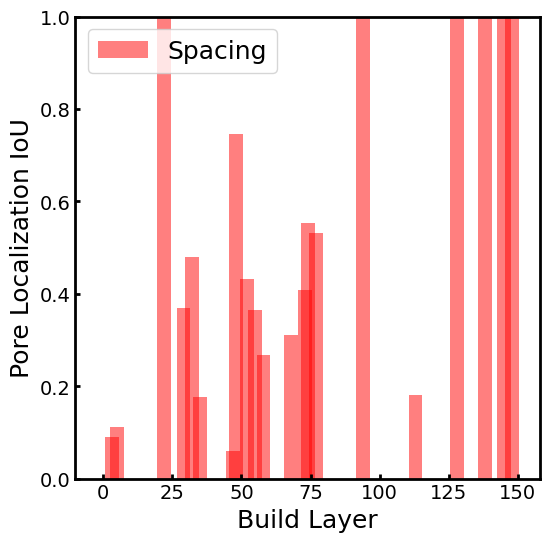

In [7]:
plt.figure(figsize=(6, 6))
plt.bar(
    spacing_sorted_build_layers,
    spacing_iou,
    color="red",
    width=5,
    alpha=0.5,
    label="Spacing",
)
# plt.bar(
#     velocity_sorted_build_layers,
#     velocity_iou,
#     color="blue",
#     width=5,
#     alpha=0.5,
#     label="Velocity"
# )

# Increase border thickness
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Add labels and title
plt.xlabel('Build Layer', fontsize=18)
plt.ylabel('Pore Localization IoU', fontsize=18)
plt.ylim([0, 1])
plt.tick_params(direction="in", labelsize=14, width=2)

plt.legend(fontsize=18)
plt.savefig(f"iou/{EPOCH}/ignore_background.png")
plt.savefig(f"../../../../../analysis/notebooks/figures/pore_localization/spacing_not_rotated_thresholded.png")
plt.show()

In [8]:
for index in tqdm(range(test_length)):
    print(index, spacing_sorted_build_layers[index], iou_ignore[index])

100%|██████████| 39/39 [00:00<00:00, 35895.95it/s]

0 0 0.0
1 3 0.09090909
2 5 0.11111111
3 12 0.0
4 17 0.0
5 22 1.0
6 23 0.0
7 29 0.36842105
8 32 0.48
9 34 0.0
10 35 0.1764706
11 47 0.05882353
12 48 0.74509805
13 52 0.43137255
14 55 0.3653846
15 58 0.26666668
16 68 0.31034482
17 73 0.4074074
18 74 0.5535714
19 77 0.53125
20 80 0.0
21 83 0.0
22 85 0.0
23 94 1.0
24 99 0.0
25 100 0.0
26 104 0.0
27 110 0.0
28 112 0.0
29 113 0.18181819
30 117 0.0
31 126 0.0
32 128 1.0
33 133 0.0
34 137 0.0
35 138 1.0
36 145 1.0
37 147 0.0
38 148 1.0


0
39
torch.Size([16, 16])
torch.Size([16, 16, 1])
layer 58


  0%|          | 0/1 [00:00<?, ?it/s]

3 0.09090909


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


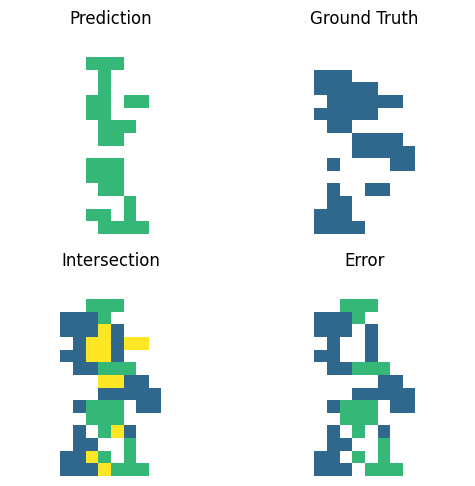

In [20]:

# indexes = train_indexes
indexes = test_indexes

dataset = Dataset(dataset_config, indexes = indexes)
INDEX = 1
print(dataset_index[INDEX])

item = dataset.__getitem__(INDEX)
length = len(dataset)
print(length)
# print(item[1])
print(target.shape)
print(item[1].shape)

print(f"layer {test_indexes[INDEX]}")

for index in tqdm([INDEX]):
# for index in tqdm(range(test_length)):
    prediction = predictions[index].squeeze()
    # print(prediction.shape)
    # target = item[1].squeeze()
    target = targets[index].squeeze()

    print(spacing_sorted_build_layers[index], spacing_iou[index])

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    cmap = plt.get_cmap('viridis')
    cmap_zero_transparent = ListedColormap(cmap(np.arange(cmap.N)))
    cmap_zero_transparent.set_bad(alpha=0)

    plt.subplots_adjust(top=0.85)

    # fig.suptitle(f"Build Layer: {spacing_sorted_build_layers[index]}, IOU: {iou:.3f} IOU (ignore bg): {iou_ignore:.3f}", fontsize=18)

    axes[0][0].clear()
    axes[0][0].set_title("Prediction", fontsize=12)
    prediction_nan = np.where(prediction == 0, np.nan, prediction + 1)
    axes[0][0].imshow(prediction_nan, vmin=0, vmax=3, cmap=cmap_zero_transparent)

    axes[0][1].clear()
    axes[0][1].set_title("Ground Truth", fontsize=12)
    target_nan = np.where(target == 0, np.nan, target)
    axes[0][1].imshow(target_nan, vmin=0, vmax=3, cmap=cmap_zero_transparent)

    axes[1][0].clear()
    axes[1][0].set_title("Intersection", fontsize=12)

    scaled_prediction = prediction * 2
    values = target + scaled_prediction
    values_nan = np.where(values == 0, np.nan, values)

    img_2 = axes[1][0].imshow(values_nan, vmin=0, vmax=3, cmap=cmap_zero_transparent)

    # Add legend for values 1 and 2
    legend_elements = [
        mpatches.Patch(color=img_2.cmap(0.33), label='Ground Truth'),
        mpatches.Patch(color=img_2.cmap(0.66), label='Prediction'),
        mpatches.Patch(color=img_2.cmap(1.0), label='Intersection'),
    ]
    # axes[1][0].legend(handles=legend_elements, loc="upper right")

    error = target - prediction + 1
    error_nan = np.where(error == 1, np.nan, error)
    error_nan = np.where(error == 0, 2, error_nan)
    error_nan = np.where(error == 2, 1, error_nan)

    axes[1][1].clear()
    axes[1][1].set_title("Error", fontsize=12)

    # Increase border thickness
    for x in range(2):
        for y in range(2):
            axes[x][y].spines['top'].set_linewidth(0)
            axes[x][y].spines['right'].set_linewidth(0)
            axes[x][y].spines['bottom'].set_linewidth(0)
            axes[x][y].spines['left'].set_linewidth(0)
            axes[x][y].tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    img_3 = axes[1][1].imshow(error_nan, vmin=0, vmax=3, cmap=cmap_zero_transparent)

    # Add legend for values 1 and 2
    legend_elements = [
        mpatches.Patch(color=img_3.cmap(0.0), label='Ground Truth'),
        mpatches.Patch(color=img_3.cmap(1.0), label='Prediction'),
    ]

    # axes[1][1].legend(handles=legend_elements, loc="upper right")
